# Dead reckoning- Extended Kalman, Mahony, Madgwick

In [1]:
import numpy as np
import pandas as pd

import scipy.signal

from numba import jit

from ahrs.common.orientation import acc2q

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [2]:
path = "./data/test_imu_B_2_1.csv"
imu_df = pd.read_csv(path)
imu_df.head(1)

,host_timestamp,arduino_timestamp,ax,ay,az,gx,gy,gz,temperature
0,35752794502900,440160,-9.7878,-0.1089,-0.5791,-0.1393,-0.1087,-0.0831,23.22


In [3]:
n = len(imu_df)
t = imu_df["arduino_timestamp"].values * 1e-3
a_s = imu_df[["ax", "ay", "az"]].values
g_s = imu_df[["gx", "gy", "gz"]].values

In [4]:
t


array([440.16 , 440.171, 440.183, ..., 489.306, 489.317, 489.328])

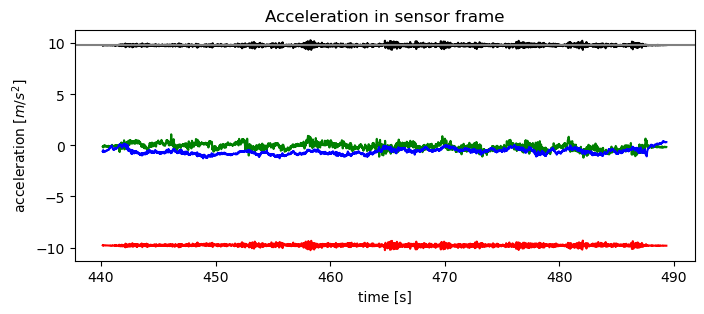

In [5]:
# Show acceleration in sensor frame
_, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, a_s[:, 0], c="r")
ax.plot(t, a_s[:, 1], c="g")
ax.plot(t, a_s[:, 2], c="b")
ax.plot(t, np.sqrt((a_s ** 2).sum(axis=-1)), c="k")
ax.axhline(9.81, c="gray")
ax.set_xlabel("time [s]")
ax.set_ylabel("acceleration $[m/s^2]$")
ax.set_title("Acceleration in sensor frame")
plt.show()

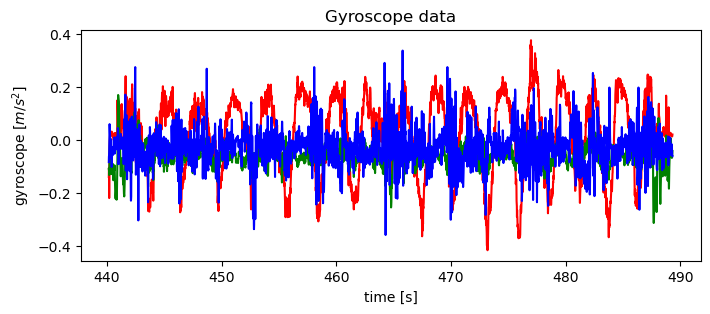

In [6]:
# Show gyroscope in sensor frame
_, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, g_s[:, 0], c="r")
ax.plot(t, g_s[:, 1], c="g")
ax.plot(t, g_s[:, 2], c="b")
ax.set_xlabel("time [s]")
ax.set_ylabel("gyroscope $[m/s^2]$")
ax.set_title("Gyroscope data")
plt.show()

#### Kalman filter

In [7]:
import numpy as np
from ahrs.filters import EKF
from ahrs.common.orientation import acc2q

ekf = EKF()            # Assuming sensors have 1000 samples each
q_sn_kalman = np.zeros((n, 4))  # Allocate array for quaternions
q_sn_kalman[0] = acc2q(a_s[0])       # initial guess
for i in range(1, n):
    ekf.Dt = t[i] - t[i - 1] # needed because sample rate is not constant 
    q_sn_kalman[i] = ekf.update(q_sn_kalman[i-1], g_s[i], a_s[i])

#### Madgwick filter

In [8]:
from ahrs.filters import Madgwick
madgwick = Madgwick()
q_sn_madgwick = np.zeros((n, 4))  # Allocate array for quaternions
q_sn_madgwick[0] = acc2q(a_s[0])       # initial guess
for i in range(1, n):
    madgwick.Dt = t[i] - t[i - 1] # needed because sample rate is not constant 
    q_sn_madgwick[i] = madgwick.updateIMU(q_sn_madgwick[i-1], g_s[i], a_s[i])

#### Mahony filter

In [9]:
from ahrs.filters import Mahony
mahony = Mahony()
q_sn_mahony = np.zeros((n, 4))  # Allocate array for quaternions
q_sn_mahony[0] = acc2q(a_s[0])       # initial guess
for i in range(1, n):
    mahony.Dt = t[i] - t[i - 1] # needed because sample rate is not constant 
    q_sn_mahony[i] = mahony.updateIMU(q_sn_mahony[i-1], g_s[i], a_s[i])

In [10]:
def conjugate(q):
    return q * np.array([1.0, -1.0, -1.0, -1.0])[..., :]

def rotation_matrix(q):
    w = q[..., 0]
    x = q[..., 1]
    y = q[..., 2]
    z = q[..., 3]
    R = np.zeros((*q.shape[:-1], 3, 3), dtype=q.dtype)
    R[..., 0, 0] = 1 - 2 * (y * y + z * z)
    R[..., 0, 1] = 2 * (x * y - z * w)
    R[..., 0, 2] = 2 * (x * z + y * w)
    R[..., 1, 0] = 2 * (x * y + z * w)
    R[..., 1, 1] = 1 - 2 * (x * x + z * z)
    R[..., 1, 2] = 2 * (y * z - x * w)
    R[..., 2, 0] = 2 * (x * z - y * w)
    R[..., 2, 1] = 2 * (y * z + x * w)
    R[..., 2, 2] = 1 - 2 * (x * x + y * y)
    return R

In [11]:
# Get associated rotation matrix, with homogeneous coordinate
R_sn_kalman = rotation_matrix(q_sn_kalman)
R_sn_madgwick = rotation_matrix(q_sn_madgwick)
R_sn_mahony = rotation_matrix(q_sn_mahony)


In [12]:
# Get measured acceleration in navigation frame
a_n_kalman = (R_sn_kalman @ a_s[:, :, None]).squeeze(-1)
a_n_madgwick = (R_sn_madgwick @ a_s[:, :, None]).squeeze(-1)
a_n_mahony = (R_sn_mahony @ a_s[:, :, None]).squeeze(-1)

In [13]:
# It seems that our calibration could be better...
kalman_med = np.median(np.sqrt((a_n_kalman ** 2).sum(axis=-1)))
madgwick_med = np.median(np.sqrt((a_n_madgwick ** 2).sum(axis=-1)))
mahony_med = np.median(np.sqrt((a_n_mahony ** 2).sum(axis=-1)))

print("Kalman median: {}, madgwick median: {} and mahony median: {}".format(kalman_med, madgwick_med, mahony_med))

Kalman median: 9.813023862441378, madgwick median: 9.81302386244138 and mahony median: 9.813023862441376


In [14]:
# Let us use this as "Earth gravity"
EARTH_GRAVITY = 9.81 # 10.0

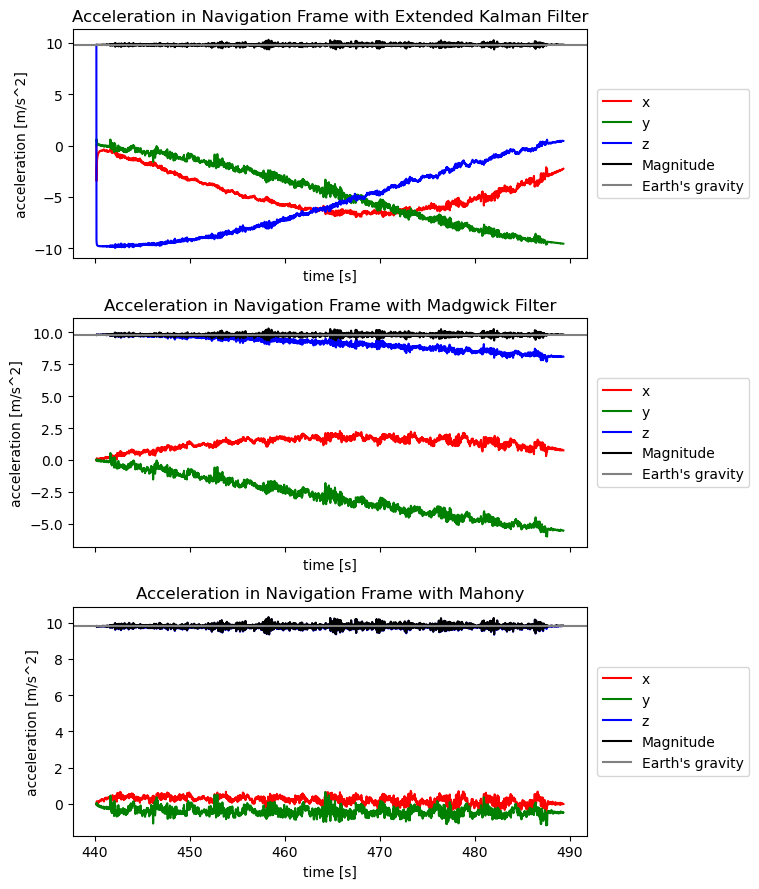

In [15]:
# Create three subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

# Plot for the first subplot
axes[0].plot(t, a_n_kalman[:, 0], c="r", label="x")
axes[0].plot(t, a_n_kalman[:, 1], c="g", label="y")
axes[0].plot(t, a_n_kalman[:, 2], c="b", label="z")
axes[0].plot(t, np.sqrt((a_n_kalman ** 2).sum(axis=-1)), c="k", label="Magnitude")
axes[0].axhline(EARTH_GRAVITY, c="gray", label="Earth's gravity")
axes[0].set_xlabel("time [s]")
axes[0].set_ylabel("acceleration [m/s^2]")
axes[0].set_title("Acceleration in Navigation Frame with Extended Kalman Filter")
axes[0].legend(loc="center right", bbox_to_anchor=(1.33, 0.5))

# Plot for the second subplot
axes[1].plot(t, a_n_madgwick[:, 0], c="r", label="x")
axes[1].plot(t, a_n_madgwick[:, 1], c="g", label="y")
axes[1].plot(t, a_n_madgwick[:, 2], c="b", label="z")
axes[1].plot(t, np.sqrt((a_n_madgwick ** 2).sum(axis=-1)), c="k", label="Magnitude")
axes[1].axhline(EARTH_GRAVITY, c="gray", label="Earth's gravity")
axes[1].set_xlabel("time [s]")
axes[1].set_ylabel("acceleration [m/s^2]")
axes[1].set_title("Acceleration in Navigation Frame with Madgwick Filter")
axes[1].legend(loc="center right", bbox_to_anchor=(1.33, 0.5))

# Plot for the third subplot
axes[2].plot(t, a_n_mahony[:, 0], c="r", label="x")
axes[2].plot(t, a_n_mahony[:, 1], c="g", label="y")
axes[2].plot(t, a_n_mahony[:, 2], c="b", label="z")
axes[2].plot(t, np.sqrt((a_n_mahony ** 2).sum(axis=-1)), c="k", label="Magnitude")
axes[2].axhline(EARTH_GRAVITY, c="gray", label="Earth's gravity")
axes[2].set_xlabel("time [s]")
axes[2].set_ylabel("acceleration [m/s^2]")
axes[2].set_title("Acceleration in Navigation Frame with Mahony")
axes[2].legend(loc="center right", bbox_to_anchor=(1.33, 0.5))

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [16]:
a_n_kalman[:, 2] = a_n_kalman[:, 2] - EARTH_GRAVITY
a_n_madgwick[:, 2] = a_n_madgwick[:, 2] - EARTH_GRAVITY
a_n_mahony[:, 2] = a_n_mahony[:, 2] - EARTH_GRAVITY

In [17]:
@jit(nopython=True)
def integrate_1d(t, dx, x0=0):
    assert t.shape == dx.shape
    (n,) = dx.shape
    x = np.zeros_like(dx)
    x[0] = x0
    for i in range(1, n):
        dt = t[i] - t[i - 1]
        x[i] = (dx[i - 1] + dx[i]) / 2 * dt + x[i - 1]
    return x

def integrate(t, dx):
    _, depth = dx.shape
    x = np.empty_like(dx)
    for d in range(depth):
        x[:, d] = integrate_1d(t, dx[:, d])
    return x

In [18]:
# Integrate acceleration to get velocity
v_n_kalman = integrate(t, a_n_kalman)
v_n_magdwick = integrate(t, a_n_madgwick)
v_n_mahony = integrate(t, a_n_mahony)




In [19]:
# filter velocity

sample_rate = 1.0 / np.mean(np.diff(t))
cutoff = 0.1 
b, a = scipy.signal.butter(6, cutoff, "highpass", fs=sample_rate) 

def highpass_filter(x):
    return scipy.signal.filtfilt(b, a, x, axis=0)


In [20]:
v_n_kalman = highpass_filter(v_n_kalman)
v_n_magdwick = highpass_filter(v_n_magdwick)
v_n_mahony = highpass_filter(v_n_mahony)

In [21]:
# Integrate velocity to get position
p_n_kalman = integrate(t, v_n_kalman)
p_n_madgwick = integrate(t, v_n_magdwick)
p_n_mahony = integrate(t, v_n_mahony)


#### Without filtering the postional data

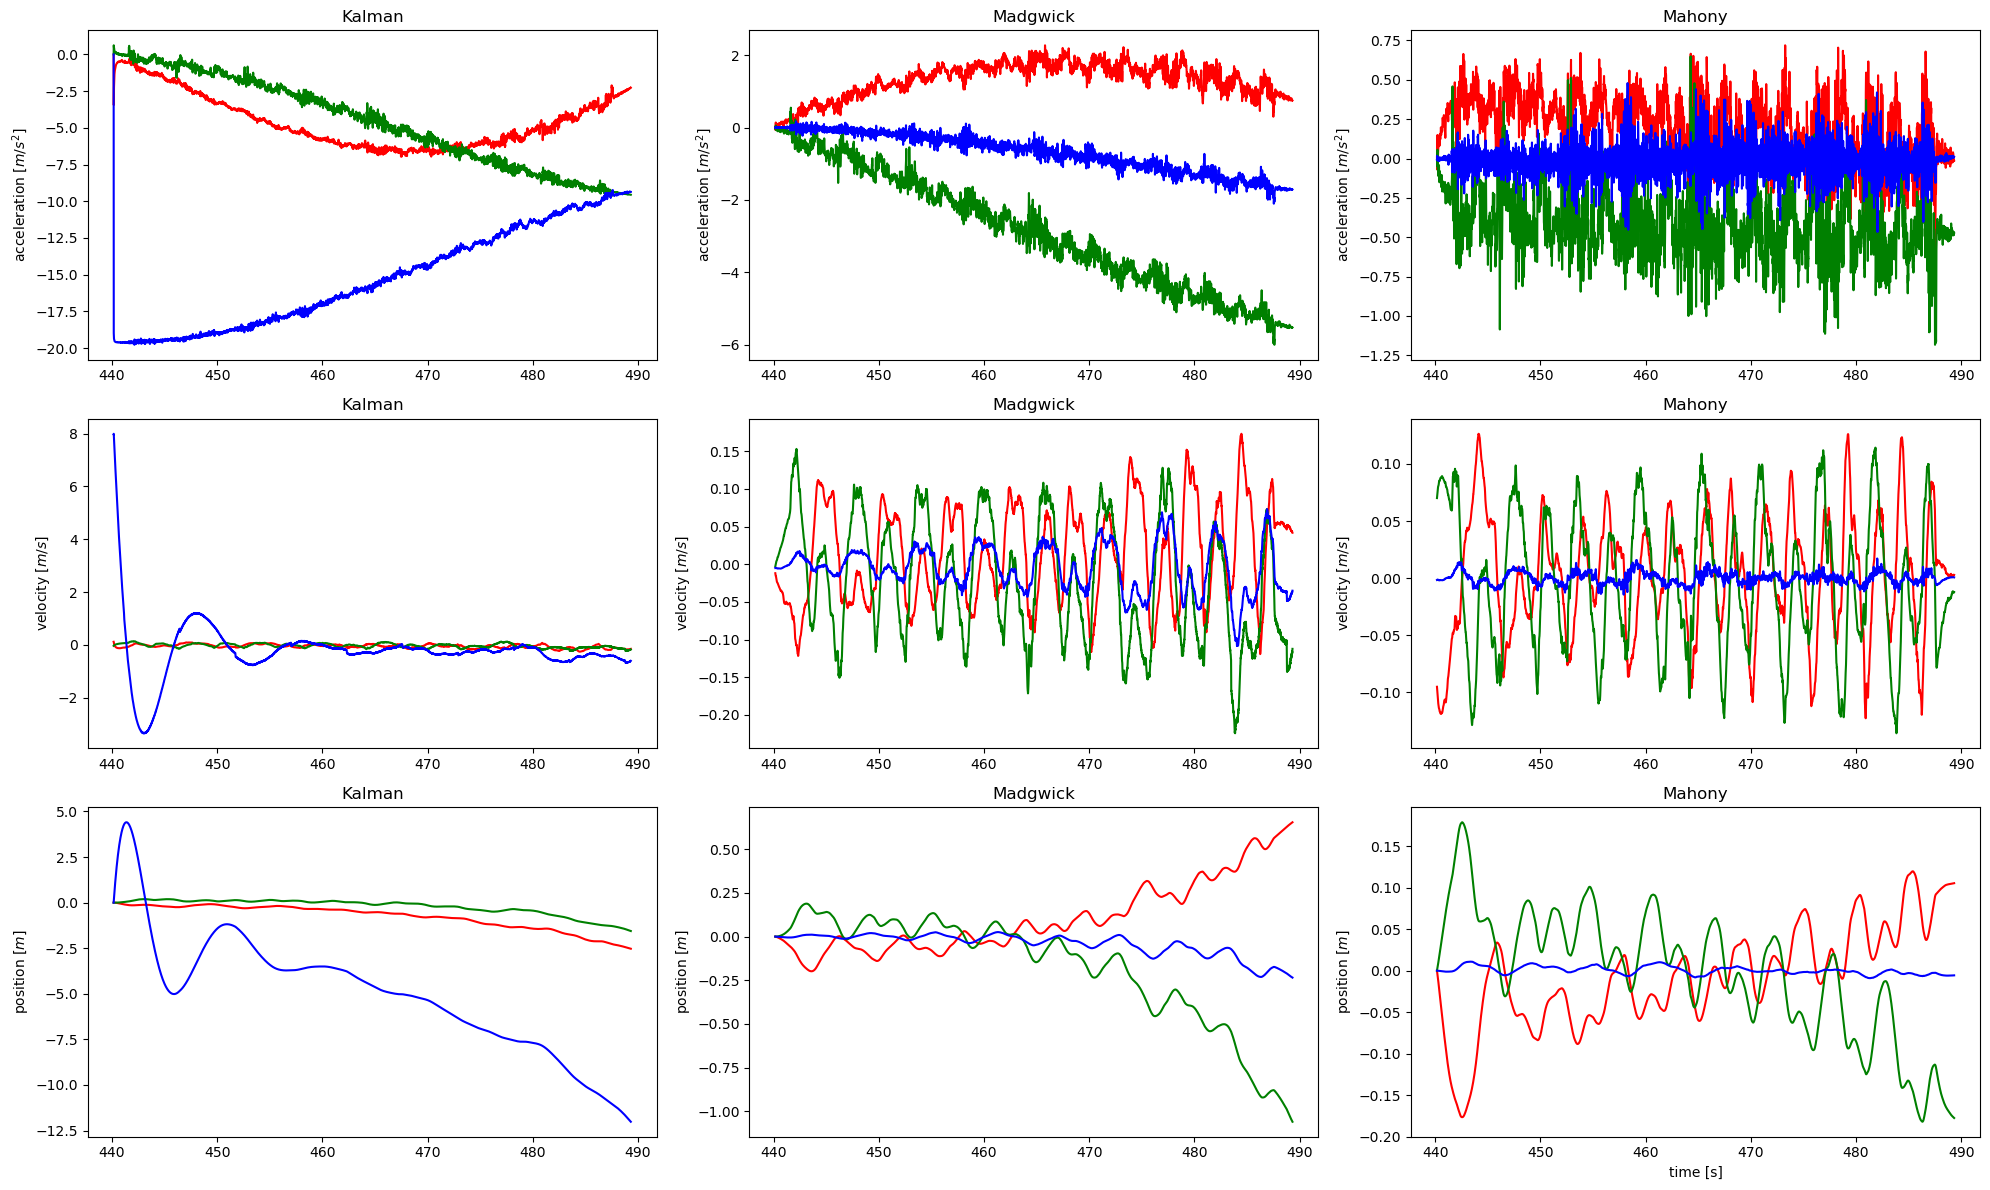

In [22]:
fig = plt.figure(figsize=(20, 12))

# Create the first set of subplots (acceleration)
axes1 = fig.add_subplot(331)
axes1.plot(t, a_n_kalman[:, 0], c="r")
axes1.plot(t, a_n_kalman[:, 1], c="g")
axes1.plot(t, a_n_kalman[:, 2], c="b")
axes1.set_ylabel("acceleration $[m/s^2]$")
axes1.set_title("Kalman")

axes2 = fig.add_subplot(332)
axes2.plot(t, a_n_madgwick[:, 0], c="r")
axes2.plot(t, a_n_madgwick[:, 1], c="g")
axes2.plot(t, a_n_madgwick[:, 2], c="b")
axes2.set_ylabel("acceleration $[m/s^2]$")
axes2.set_title("Madgwick")

axes3 = fig.add_subplot(333)
axes3.plot(t, a_n_mahony[:, 0], c="r")
axes3.plot(t, a_n_mahony[:, 1], c="g")
axes3.plot(t, a_n_mahony[:, 2], c="b")
axes3.set_ylabel("acceleration $[m/s^2]$")
axes3.set_title("Mahony")

# Create the second set of subplots (velocity)
axes4 = fig.add_subplot(334)
axes4.plot(t, v_n_kalman[:, 0], c="r")
axes4.plot(t, v_n_kalman[:, 1], c="g")
axes4.plot(t, v_n_kalman[:, 2], c="b")
axes4.set_ylabel("velocity $[m/s]$")
axes4.set_title("Kalman")

axes5 = fig.add_subplot(335)
axes5.plot(t, v_n_magdwick[:, 0], c="r")
axes5.plot(t, v_n_magdwick[:, 1], c="g")
axes5.plot(t, v_n_magdwick[:, 2], c="b")
axes5.set_ylabel("velocity $[m/s]$")
axes5.set_title("Madgwick")

axes6 = fig.add_subplot(336)
axes6.plot(t, v_n_mahony[:, 0], c="r")
axes6.plot(t, v_n_mahony[:, 1], c="g")
axes6.plot(t, v_n_mahony[:, 2], c="b")
axes6.set_ylabel("velocity $[m/s]$")
axes6.set_title("Mahony")

# Create the third set of subplots (position)
axes7 = fig.add_subplot(337)
axes7.plot(t, p_n_kalman[:, 0], c="r")
axes7.plot(t, p_n_kalman[:, 1], c="g")
axes7.plot(t, p_n_kalman[:, 2], c="b")
axes7.set_ylabel("position $[m]$")
axes7.set_title("Kalman")

axes8 = fig.add_subplot(338)
axes8.plot(t, p_n_madgwick[:, 0], c="r")
axes8.plot(t, p_n_madgwick[:, 1], c="g")
axes8.plot(t, p_n_madgwick[:, 2], c="b")
axes8.set_ylabel("position $[m]$")
axes8.set_title("Madgwick")

axes9 = fig.add_subplot(339)
axes9.plot(t, p_n_mahony[:, 0], c="r")
axes9.plot(t, p_n_mahony[:, 1], c="g")
axes9.plot(t, p_n_mahony[:, 2], c="b")
axes9.set_xlabel("time [s]")
axes9.set_ylabel("position $[m]$")
axes9.set_title("Mahony")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

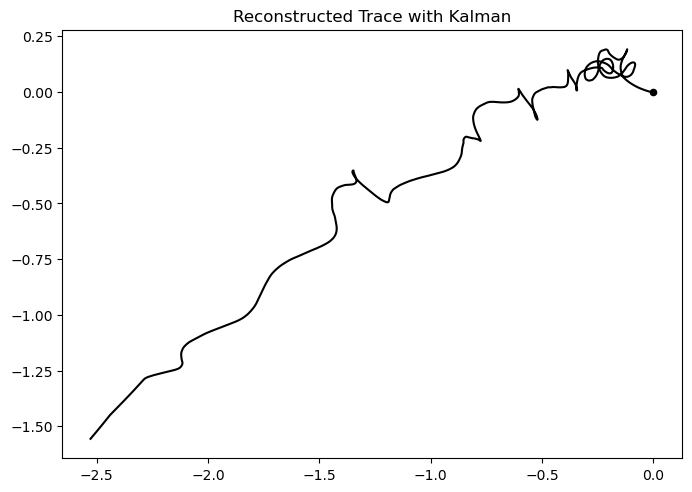

In [23]:
# Show position in horizontal plane
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(p_n_kalman[:, 0], p_n_kalman[:, 1], c="k")
ax.scatter(p_n_kalman[0, 0], p_n_kalman[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.title("Reconstructed Trace with Kalman")
plt.show()

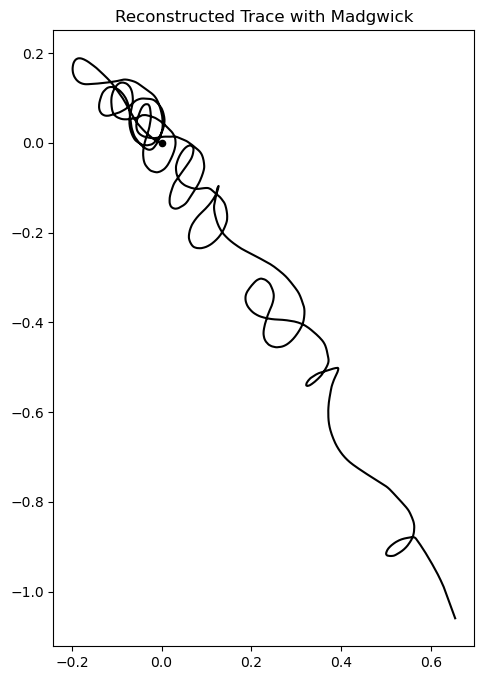

In [24]:
# Show position in horizontal plane
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(p_n_madgwick[:, 0], p_n_madgwick[:, 1], c="k")
ax.scatter(p_n_madgwick[0, 0], p_n_madgwick[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.title("Reconstructed Trace with Madgwick")
plt.show()

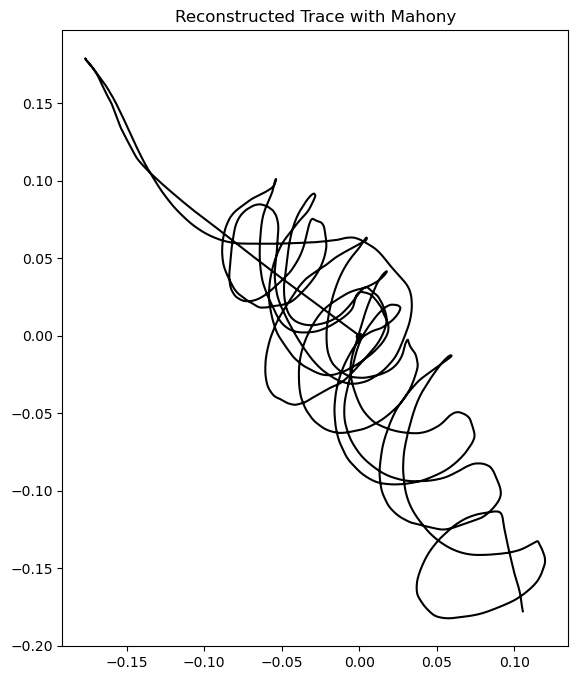

In [25]:
# Show position in horizontal plane
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(p_n_mahony[:, 0], p_n_mahony[:, 1], c="k")
ax.scatter(p_n_mahony[0, 0], p_n_mahony[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.title("Reconstructed Trace with Mahony")
plt.show()

#### With filtering the positional data

In [31]:
# filter position
# filter positional data

p_n_kalman = highpass_filter(p_n_kalman)
p_n_madgwick = highpass_filter(p_n_madgwick)
p_n_mahony = highpass_filter(p_n_mahony)

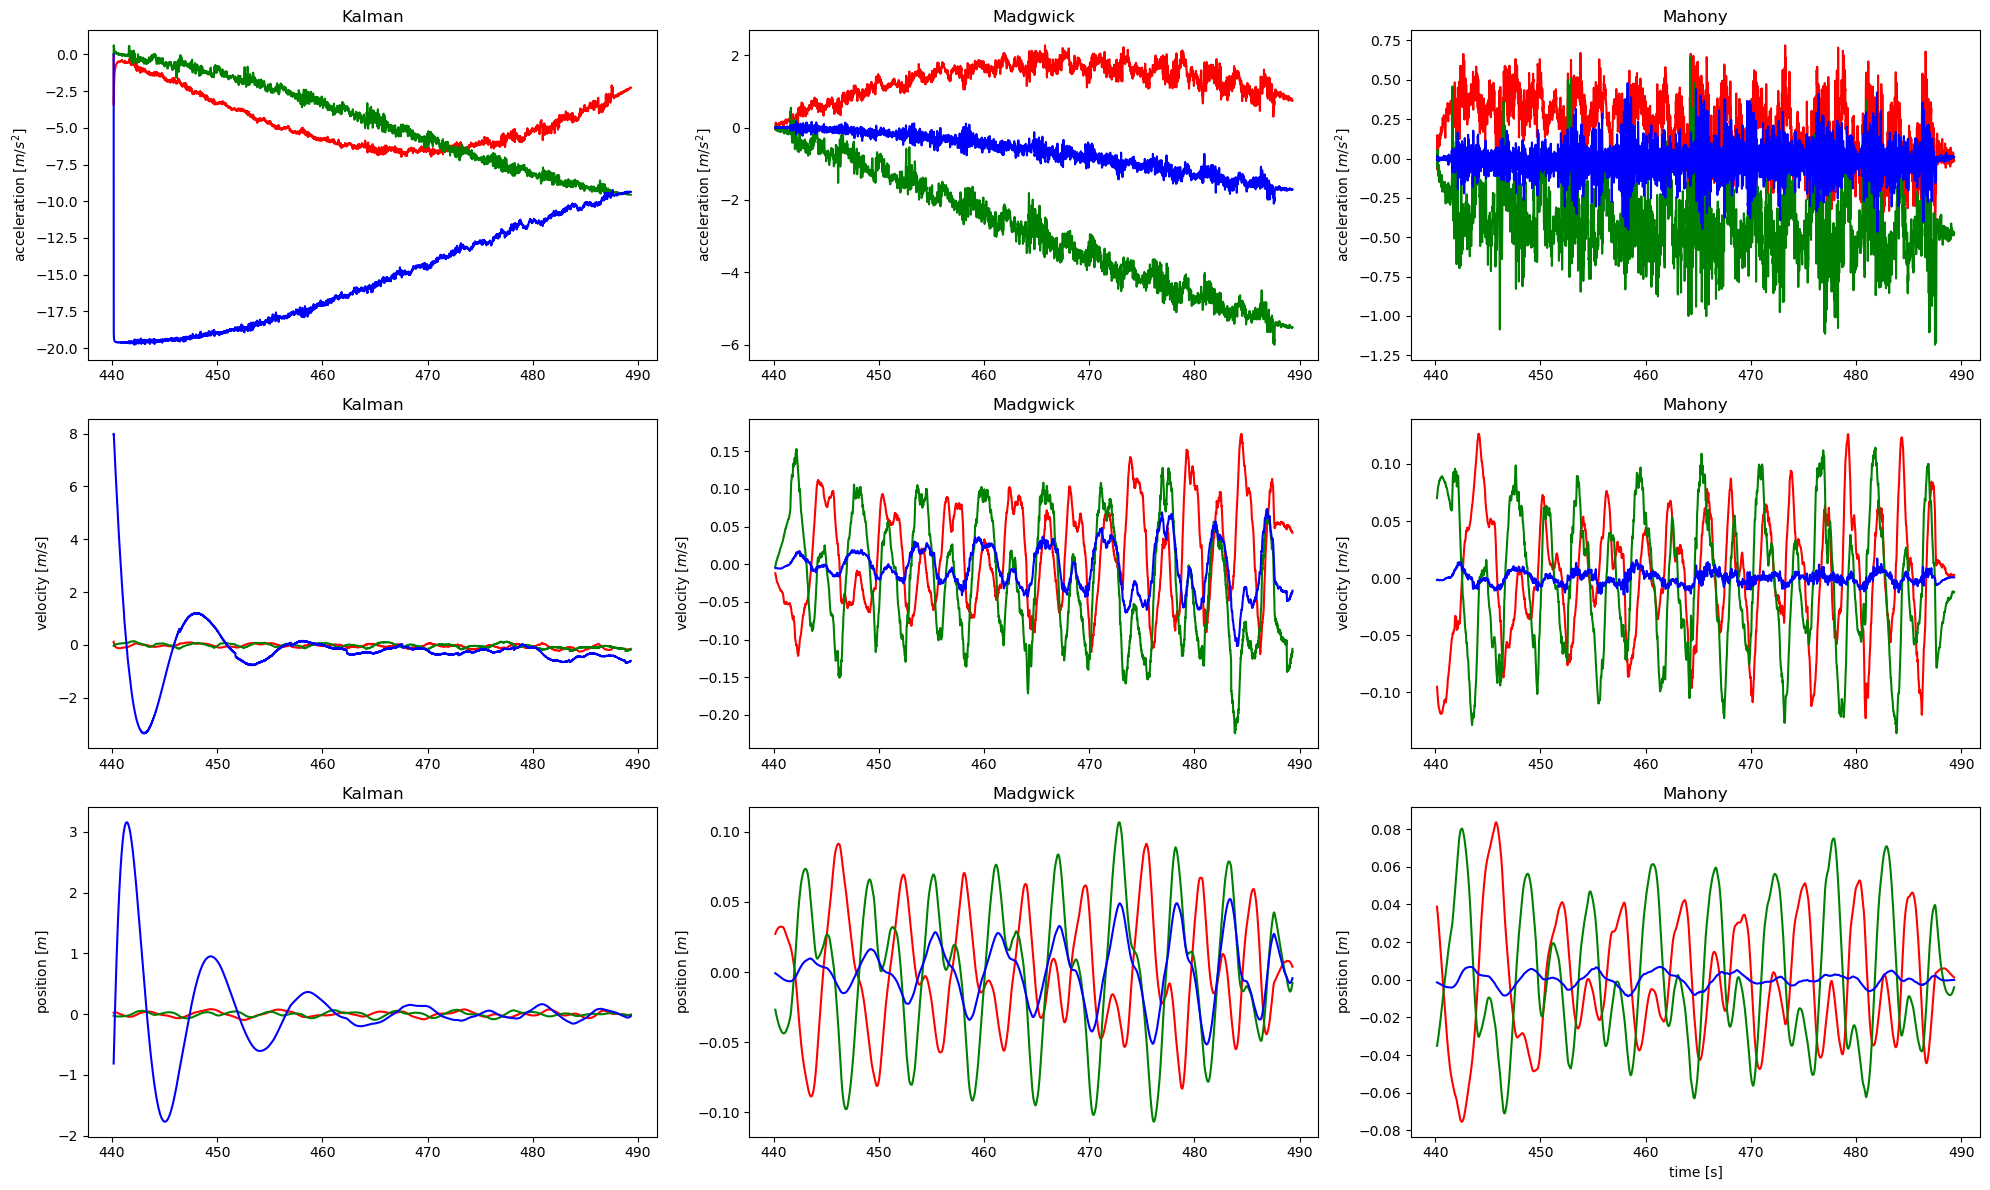

In [32]:
fig = plt.figure(figsize=(20, 12))

# Create the first set of subplots (acceleration)
axes1 = fig.add_subplot(331)
axes1.plot(t, a_n_kalman[:, 0], c="r")
axes1.plot(t, a_n_kalman[:, 1], c="g")
axes1.plot(t, a_n_kalman[:, 2], c="b")
axes1.set_ylabel("acceleration $[m/s^2]$")
axes1.set_title("Kalman")

axes2 = fig.add_subplot(332)
axes2.plot(t, a_n_madgwick[:, 0], c="r")
axes2.plot(t, a_n_madgwick[:, 1], c="g")
axes2.plot(t, a_n_madgwick[:, 2], c="b")
axes2.set_ylabel("acceleration $[m/s^2]$")
axes2.set_title("Madgwick")

axes3 = fig.add_subplot(333)
axes3.plot(t, a_n_mahony[:, 0], c="r")
axes3.plot(t, a_n_mahony[:, 1], c="g")
axes3.plot(t, a_n_mahony[:, 2], c="b")
axes3.set_ylabel("acceleration $[m/s^2]$")
axes3.set_title("Mahony")

# Create the second set of subplots (velocity)
axes4 = fig.add_subplot(334)
axes4.plot(t, v_n_kalman[:, 0], c="r")
axes4.plot(t, v_n_kalman[:, 1], c="g")
axes4.plot(t, v_n_kalman[:, 2], c="b")
axes4.set_ylabel("velocity $[m/s]$")
axes4.set_title("Kalman")

axes5 = fig.add_subplot(335)
axes5.plot(t, v_n_magdwick[:, 0], c="r")
axes5.plot(t, v_n_magdwick[:, 1], c="g")
axes5.plot(t, v_n_magdwick[:, 2], c="b")
axes5.set_ylabel("velocity $[m/s]$")
axes5.set_title("Madgwick")

axes6 = fig.add_subplot(336)
axes6.plot(t, v_n_mahony[:, 0], c="r")
axes6.plot(t, v_n_mahony[:, 1], c="g")
axes6.plot(t, v_n_mahony[:, 2], c="b")
axes6.set_ylabel("velocity $[m/s]$")
axes6.set_title("Mahony")

# Create the third set of subplots (position)
axes7 = fig.add_subplot(337)
axes7.plot(t, p_n_kalman[:, 0], c="r")
axes7.plot(t, p_n_kalman[:, 1], c="g")
axes7.plot(t, p_n_kalman[:, 2], c="b")
axes7.set_ylabel("position $[m]$")
axes7.set_title("Kalman")

axes8 = fig.add_subplot(338)
axes8.plot(t, p_n_madgwick[:, 0], c="r")
axes8.plot(t, p_n_madgwick[:, 1], c="g")
axes8.plot(t, p_n_madgwick[:, 2], c="b")
axes8.set_ylabel("position $[m]$")
axes8.set_title("Madgwick")

axes9 = fig.add_subplot(339)
axes9.plot(t, p_n_mahony[:, 0], c="r")
axes9.plot(t, p_n_mahony[:, 1], c="g")
axes9.plot(t, p_n_mahony[:, 2], c="b")
axes9.set_xlabel("time [s]")
axes9.set_ylabel("position $[m]$")
axes9.set_title("Mahony")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

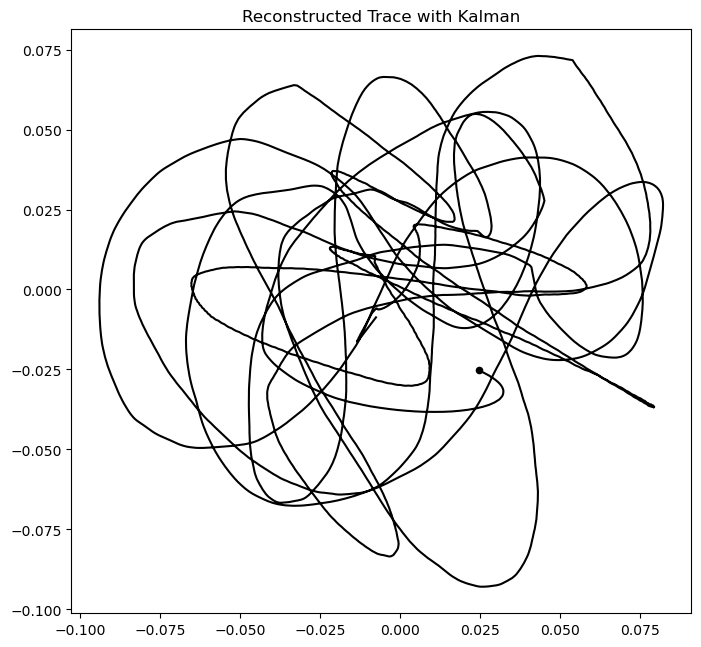

In [33]:
# Show position in horizontal plane
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(p_n_kalman[:, 0], p_n_kalman[:, 1], c="k")
ax.scatter(p_n_kalman[0, 0], p_n_kalman[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.title("Reconstructed Trace with Kalman")
plt.show()

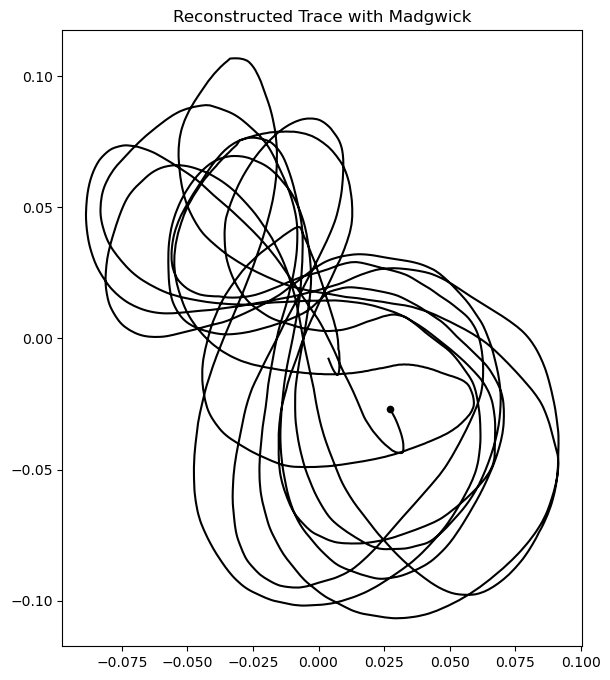

In [34]:
# Show position in horizontal plane
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(p_n_madgwick[:, 0], p_n_madgwick[:, 1], c="k")
ax.scatter(p_n_madgwick[0, 0], p_n_madgwick[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.title("Reconstructed Trace with Madgwick")
plt.show()

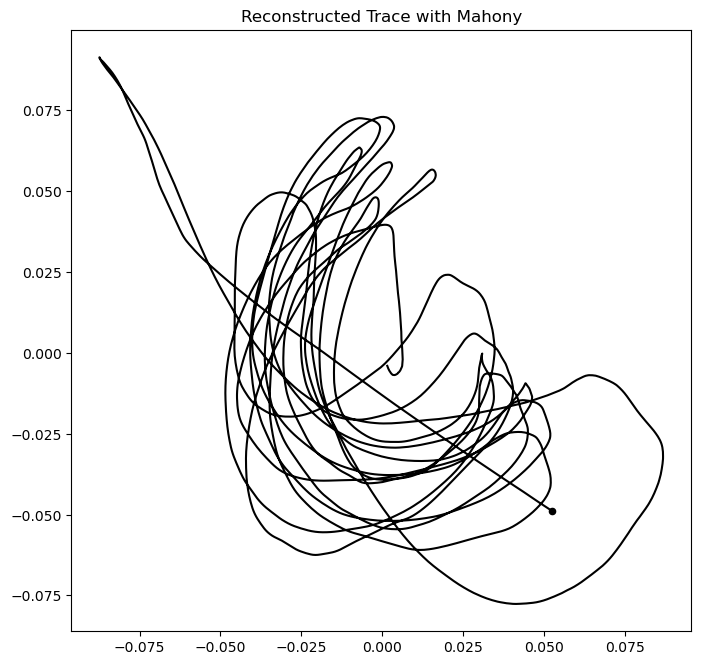

In [30]:
# Show position in horizontal plane
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(p_n_mahony[:, 0], p_n_mahony[:, 1], c="k")
ax.scatter(p_n_mahony[0, 0], p_n_mahony[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.title("Reconstructed Trace with Mahony")
plt.show()